In [1]:
import numpy as np
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
def split_digits(X, y):
    '''
    Implementing the customary split of the Digits dataset into 
    1000 training and 1000 testing examples. Rows 0-100 are
    training examples, 101-200 are testing examples, 201-300
    are training examples, and so on.
    ---------------
    Input arguments: 
    X:  matrix of dimension 2000 x 240
        contains intensity values of 240 pixels for 2000
        greyscale images of digits, values range from [0,6]
    y:  vector of length 2000
        contains labels {0,1,2,3,4,5,6,7,8,9}
    '''

    X_train = np.array(X[0:100])
    y_train = np.array(y[0:100])

    end = 300
    for i in range(9):
        start = end - 100
        X_train = np.append(X_train, X[start:end], axis=0)
        y_train = np.append(y_train, y[start:end], axis=0)
        end += 200 

    X_test = np.array(X[100:200])
    y_test = np.array(y[100:200])

    end = 400
    for i in range(9):
        start = end - 100
        X_test = np.append(X_test, X[start:end], axis=0)
        y_test = np.append(y_test, y[start:end], axis=0)
        end += 200 

    return X_train, y_train, X_test, y_test

In [5]:
# import dataset
with open('/Users/noaschwensfeier/ML_PYTHON/Machine_learning_Project/dataset.txt','r') as data:
    X = [line.strip().split("  ") for line in data]
    y = [i for i in range(10) for j in range(200)] # create labels

X = np.array(X, dtype=np.int32)
y = np.array(y)
#print(X.shape)
#print(y.shape)

N = X.shape[0]
n = X.shape[1]
print(n)


240


In [6]:
# split dataset into 50/50 according to custom in Digits dataset
X_train, y_train, X_test, y_test = split_digits(X,y)

In [54]:
#C_list = [0.001, 0.01, 0.1, 1] #regularization
n_comp_list = np.linspace(2,240, 240-1)
print(n_comp_list)
results = np.empty((240, 3))
colnames = ['n_comp', 'empirical_risk', 'risk']
iter = 0

#for c in C_list: 

for  n_comp in n_comp_list:

    n_comp = int(n_comp)
    
    # dimensionality reduction 
    pca = PCA(n_components=n_comp, svd_solver='full')
    X_cmpr = pca.fit_transform(X_train)

    # logistic regression
    classifier = LogisticRegression(penalty='l2', solver='saga', tol=.1, multi_class='multinomial')
    classifier.fit(X_cmpr, y_train) #fit to train data
    train_score = classifier.score(X_cmpr, y_train) #calculate train acc

    X_cmpr_test = pca.transform(X_test) #fit pca to test data
    test_score = classifier.score(X_cmpr_test, y_test) #calculate test acc

    results[iter, 0] = n_comp
    results[iter, 1] = train_score
    results[iter, 2] = test_score

    iter +=1

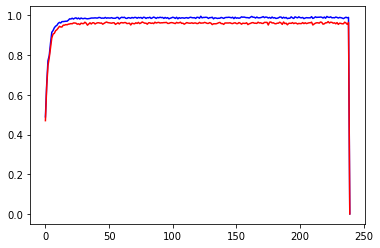

In [55]:
#print(results)
plt.plot(range(240), results[:,1], color='blue')
plt.plot(range(240), results[:,2], color='red')